In [64]:
from manim import *
from numpy import linalg as npl
import math
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline
from multiprocessing import Process

video1_scene = " -v WARNING --progress_bar None --disable_caching magnus_full_Scene"
image1_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s magnus_full_Scene"

video2_scene = " -v WARNING --progress_bar None --disable_caching magnus_Scene"
image2_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s magnus_Scene"

In [69]:
# globale Konstanten
g = 90.81
omega = -0.75               # Winkelgeschwindigkeit
m = 0.2                   # Masse
A_eff = 1.975               # effektvive Fläche des Objektes
rho = 1                 # Dichte des Mediums
c_W = 0.05                  # Reibungskoefficzient
R = 1                 

# Systemparameter
C_R = c_W / 2 * rho * A_eff / m
C_M = 2 * R * rho * A_eff / m


# Functions for numerical Integration
def ODE_Magnus(t, y_array, f_array, params):
    v_x = y_array[2]
    v_y = y_array[3]

    f_array[0] = v_x
    f_array[1] = v_y
    f_array[2] = -params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_x - params['C_M'] * omega * v_y
    f_array[3] = -g - params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_y + params['C_M'] * omega * v_x
    return


def DE_trans(t, y_array, f_array, params):

    alpha = np.arctan2(y_array[3], y_array[2])
    
    # if y_array[0] + (0.75 / 2 + 0.375 / 2) * np.cos(alpha) +0.05 >= 1:
    if y_array[0] + 0.3 >= 1:
        v_x = 0
    else:
        v_x = y_array[2]
    v_y = y_array[3]

    f_array[0] = v_x
    f_array[1] = v_y
    f_array[2] = -params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_x
    f_array[3] = -g - params['C_R'] * np.sqrt(v_x**2 + v_y**2) * v_y
    return


def rk4_step(t, delta_t, y_array, ode, params):
    k1 = np.zeros_like(y_array)
    k2 = np.zeros_like(y_array)
    k3 = np.zeros_like(y_array)
    k4 = np.zeros_like(y_array)
    support = np.zeros_like(y_array)
    ode(t, y_array, k1, params) 

    # Berechnung k1 = f(t, y) * dt und support = y + k1/2
    k1 *= delta_t
    support = y_array + k1 / 2

    # Berechnung k2 = f(t+dt/2, y+k1/2) * dt und support = y + k2/2
    ode(t+delta_t/2, support, k2, params)
    k2 *= delta_t
    support = y_array + k2 / 2

    # Berechnung k3 = f(t+dt/2, y+k2/2) * dt und support = y + k3
    ode(t+delta_t/2, support, k3, params)
    k3 *= delta_t
    support = y_array + k3

    # Berechnung k4 = f(t+dt, y+k2) * dt und y_(i+1)
    ode(t+delta_t, support, k4, params)
    k4 *= delta_t
    y_array += (k1 + 2*k2 + 2*k3 + k4) / 6; 
    return


# Erzeugung der Daten
t = 0
T_max = 5
N = int(10e3)
delta_t = T_max / N

state_0 = np.array([-3.5, 1.5, 50, -20], float)
trans_0 = np.array([-3.5, 1.5, 50, -20], float)
param_dick = {'C_R': C_R, 'C_M': C_M}

state_array = np.zeros((N, 4))
state_array[0,:] = state_0
trans_array = np.zeros((N, 4))
trans_array[0,:] = state_0
for i in range(1, N):
    t += delta_t
    rk4_step(t, delta_t, state_0, ODE_Magnus, param_dick)
    rk4_step(t, delta_t, trans_0, DE_trans, param_dick)
    state_array[i,:] = state_0
    trans_array[i,:] = trans_0

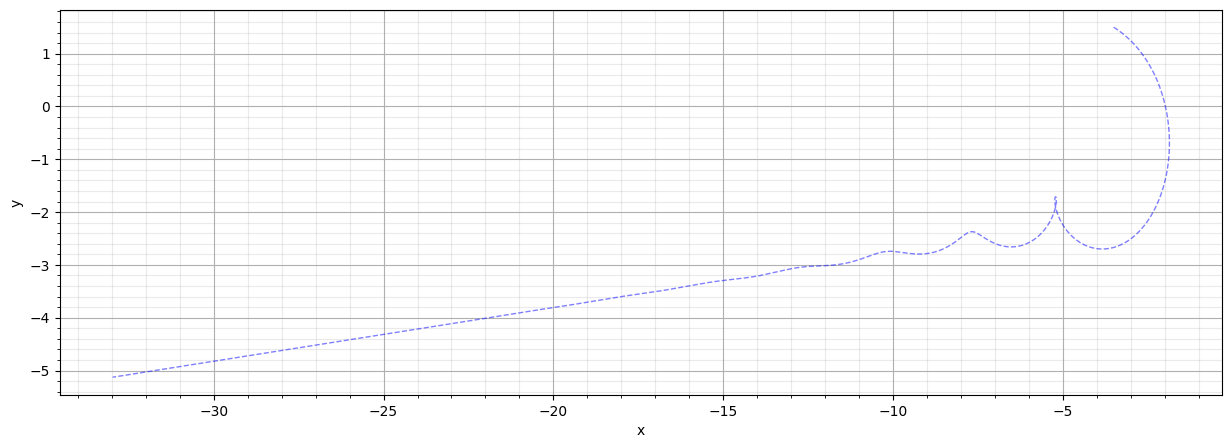

In [70]:
# Darstellung Trajektorie in Matplotlib
fig, ax = plt.subplots(figsize=(15,5))

ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.plot(state_array[:,0], state_array[:,1], color = 'blue', alpha = 0.5, linestyle = '--', linewidth = 1)#, label = f'Runge-Kutta 2')

# ax.legend()
# ax.legend(loc="upper left")

plt.show()

In [71]:
# Beschleunigungen aus Zustandsarray
def a_x(v_x, v_y):
    return - C_M * omega * v_y

def a_y(v_x, v_y):
    return C_M * omega * v_x

In [79]:
%%manim -qh --fps 60 $video1_scene


class magnus_full_Scene(ThreeDScene):
	def construct(self):
		self.camera.background_color=WHITE
		CVC = Text('CVC', font_size = 12, weight = BOLD, color = BLACK, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
		# self.add(CVC)

		eq_magnus = Tex(r"$\Vec{F}_\mathrm{M}\propto\Vec{w}\times\Vec{v}$", color = BLACK, font_size = 48).align_on_border(LEFT, buff = 9.75).shift(3*UP)
		eq_magnus[0][4:6].set_color(RED)
		eq_magnus[0][7:9].set_color(GREEN)
		eq_magnus_red_box = SurroundingRectangle(eq_magnus[0][4:6], buff = .1, color = RED)
		eq_magnus_green_box = SurroundingRectangle(eq_magnus[0][7:9], buff = .1, color = GREEN)
		eq_magnus_black_box = SurroundingRectangle(eq_magnus[0][0:3], buff = .1, color = BLACK)

		# Strömungsgeschwindigkeit
		stream_text = Tex(r"Strömungsgeschwindigkeit:", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9).shift(1.75*UP)
		u_text = Tex(r"$\Vec{u}=-\Vec{v}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 10.5).shift(1.25*UP)
		u_text[0][0:2].set_color(BLUE)
		u_text[0][3:6].set_color(GREEN)
		u_text_blue_box = SurroundingRectangle(u_text[0][0:1], buff = .1, color = BLUE)


		# Object
		cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
		cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
		cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
		cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
		cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)

		cylinder_circ_b = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
		cylinder_line1_b = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
		cylinder_line2_b = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
		cylinder_line3_b = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
		cylinder_line4_b = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)

		rect_trans = Rectangle(height = 0.375, width = 0.75, fill_color = RED, fill_opacity = 0.5, stroke_opacity = 1, stroke_color = RED)
		rect_line1_trans = Line([0.75 / 2, -0.375 / 2, 0], [-0.75 / 2, 0.375 / 2, 0], color = RED, stroke_opacity = 1)
		rect_line2_trans = Line([0.75 / 2, 0.375 / 2, 0], [-0.75 / 2, -0.375 / 2, 0], color = RED, stroke_opacity = 1)

		rect_top_up = Line([0.75 / 2, 0.375 / 2, 0], [0, 0.375 / 2, 0], stroke_opacity = 1, stroke_color = RED)
		rect_top_down = Line([0.75 / 2, -0.375 / 2, 0], [0, 0.375 / 2, 0], stroke_opacity = 1, stroke_color = RED)
		rect_top = Polygon([0.75 / 2, 0.375 / 2 - 0.02, 0], [0.75 / 2 + 0.375 / 2, 0, 0], [0.75 / 2, -0.375 / 2 + 0.02, 0], stroke_opacity = 1, stroke_color = RED, fill_color = RED, fill_opacity = 0.5)
		# rect_arc_trans = Arc(radius = 0.375 / 2, arc_center = [0.75 / 2, 0, 0], start_angle = -PI/2, angle = PI, color = RED, stroke_opacity = 1)
		# rect_sector1_trans = Sector(outer_radius = 0.375 / 2, fill_color = RED, fill_opacity = 0.5).shift(0.75 / 2 * RIGHT)
		# rect_sector2_trans = Sector(outer_radius = 0.375 / 2, fill_color = RED, fill_opacity = 0.5).shift(0.75 / 2 * RIGHT + 0.375 / 2 * DOWN).rotate(axis = [0, 0, 1], angle = -2*PI/4)

		box_cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
		box_cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
		box_cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
		box_cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
		box_cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)


		# Linear Start
		dt_lin = 0.05
		dt_trans = 15
		x_0_lin = np.linspace(state_array[0, 0] - state_array[0, 2] * dt_lin, state_array[0,0], int(dt_lin / delta_t))
		y_0_lin = np.linspace(state_array[0, 1] - state_array[0, 3] * dt_lin, state_array[0,1], int(dt_lin / delta_t))

		v_x_0_lin = np.linspace(state_array[0, 2], state_array[0, 2], int(dt_lin / delta_t))
		v_y_0_lin = np.linspace(state_array[0, 3], state_array[0, 3], int(dt_lin / delta_t))

		alpha = np.arctan2(v_y_0_lin[0], v_x_0_lin[0])

		cylinder_group = VGroup(cylinder_circ, cylinder_line1, cylinder_line2, cylinder_line3, cylinder_line4).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)
		# cylinder_trans_group = VGroup(rect_trans, rect_line1_trans, rect_line2_trans, rect_top).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = alpha)
		cylinder_trans_group = VGroup(cylinder_circ_b, cylinder_line1_b, cylinder_line2_b, cylinder_line3_b, cylinder_line4_b).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)



		cylinder_group.generate_target()
		cylinder_group.target.move_to([state_array[0,0], state_array[0,1], 0])


		# Water
		left_border = -6
		bottom_border = -3
		right_border = 1
		top_border = 1.5

		left_line = Line([left_border, bottom_border, 0], [left_border, top_border + 0.5, 0], color = BLUE)
		right_line = Line([right_border, bottom_border, 0], [right_border, top_border + 0.5, 0], color = BLUE)
		bottom_line = Line([left_border, bottom_border, 0], [right_border, bottom_border, 0], color = BLUE)

		water = Polygon([left_border, bottom_border, 0], [left_border, top_border, 0], [right_border, top_border, 0], [right_border, bottom_border, 0], color = BLUE, fill_opacity = 0.2)
		water_group = VGroup(left_line, right_line, bottom_line, water)


		# Geschwindigkeit
		v_factor = 25
		v_tilt = 3
		mag_tilt = 4

		x_i = state_array[0,0]
		y_i = state_array[0,1]
		v_x_i = state_array[0,2] / v_factor
		v_y_i = state_array[0,3] / v_factor
		v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )
		v_vector = Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt, y_i + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1)


		# Magnuskraft
		magnus_vector = Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)


		# Erzeugung der Iter
		x_cylinder_iter = iter(np.append(x_0_lin, state_array[:,0], axis = 0))
		y_cylinder_iter = iter(np.append(y_0_lin, state_array[:,1], axis = 0))

		x_cylinder_trans_iter = iter(np.append(x_0_lin, trans_array[:,0], axis = 0))
		y_cylinder_trans_iter = iter(np.append(y_0_lin, trans_array[:,1], axis = 0))

		v_x_cylinder_iter = iter(np.append(v_x_0_lin, state_array[:,2] / v_factor, axis = 0))
		v_y_cylinder_iter = iter(np.append(v_y_0_lin, state_array[:,3] / v_factor, axis = 0))

		v_x_cylinder_trans_pre_iter = iter(np.append(v_x_0_lin, trans_array[:,2], axis = 0))
		v_y_cylinder_trans_pre_iter = iter(np.append(v_y_0_lin, trans_array[:,3], axis = 0))

		v_x_cylinder_trans_post_iter = iter(np.append(v_x_0_lin, trans_array[1:,2], axis = 0))
		v_y_cylinder_trans_post_iter = iter(np.append(v_y_0_lin, trans_array[1:,3], axis = 0))

		alpha = np.arctan2(v_y_i, v_x_i)


		# Box
		box_origin = [4, -1, 0]
		box_side = 3
		box_rect = Rectangle(width = box_side, height = box_side, stroke_width = 1, color = BLACK).move_to(box_origin)
		box_ax = NumberPlane(
			x_range = [-box_side / 2, box_side / 2, 1], y_range = [-box_side / 2, box_side / 2, 1], x_length = 3, y_length = 3, 
			axis_config = {"stroke_width": 1, "stroke_opacity": 0.125, "stroke_color": BLACK},
			background_line_style = {"stroke_color": BLACK, "stroke_opacity": 0.125}).move_to(box_origin)


		box_cylinder_upper_arc = Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
		box_cylinder_lower_arc = Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
		box_cylinder_arc = VGroup(box_cylinder_upper_arc, box_cylinder_lower_arc)
		box_omega_pos = [box_origin[0] + 1.25, box_origin[1] + 1.25, 0]

		box_omega_circle = Circle(radius = 0.125, color = RED, fill_color = RED, fill_opacity = 0, stroke_width = 2).move_to(box_omega_pos)
		box_omega_line1 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED, stroke_width = 2).rotate(axis = [0, 0, 1], angle = PI/4).move_to(box_omega_pos)
		box_omega_line2 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED, stroke_width = 2).rotate(axis = [0, 0, 1], angle = -PI/4).move_to(box_omega_pos)
		box_omega = VGroup(box_omega_circle, box_omega_line1, box_omega_line2)

		box_cylinder_upper_velocity = Line(
			[box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
			color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

		box_cylinder_lower_velocity = Line(
			[box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
			color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

		box_cylinder_velocity = VGroup(box_cylinder_upper_velocity, box_cylinder_lower_velocity)

		box_magnus = Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)

		box_group = VGroup(box_rect, box_ax)
		box_cylinder_group = VGroup(box_cylinder_circ, box_cylinder_line1, box_cylinder_line2, box_cylinder_line3, box_cylinder_line4).move_to(box_origin)
    
       
		# Zylinder-Updater
		def cylinder_lin_move_updater(cylinder):
			x_i = next(x_cylinder_iter)
			y_i = next(y_cylinder_iter)

			v_x_i = next(v_x_cylinder_iter)
			v_y_i = next(v_y_cylinder_iter)
			
			cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)


		def cylinder_lin_trans_move_updater(cylinder):
			x_i_trans = next(x_cylinder_trans_iter)
			y_i_trans = next(y_cylinder_trans_iter)

			v_x_i_pre = next(v_x_cylinder_trans_pre_iter)
			v_y_i_pre = next(v_y_cylinder_trans_pre_iter)

			v_x_i_post = next(v_x_cylinder_trans_post_iter)
			v_y_i_post = next(v_y_cylinder_trans_post_iter)

			cylinder.move_to([x_i_trans, y_i_trans, 0])

        
		# Non-linear Updater
		trans_traj_group = VGroup()
		def cylinder_trans_move_updater(cylinder):
			x_i_trans = next(x_cylinder_trans_iter)
			y_i_trans = next(y_cylinder_trans_iter)

			v_x_i_pre = next(v_x_cylinder_trans_pre_iter)
			v_y_i_pre = next(v_y_cylinder_trans_pre_iter)

			v_x_i_post = next(v_x_cylinder_trans_post_iter)
			v_y_i_post = next(v_y_cylinder_trans_post_iter)

			alpha_pre = np.arctan2(v_y_i_pre, v_x_i_pre)
			alpha_post = np.arctan2(v_y_i_post, v_x_i_post)

			trans_connect = Line([x_i_trans, y_i_trans, 0], cylinder.get_center(), color = RED, stroke_opacity = 0.25)
			self.add(trans_connect)
			trans_traj_group.add(trans_connect)

			cylinder.move_to([x_i_trans, y_i_trans, 0]).rotate(axis = [0, 0, 1], angle = alpha_post-alpha_pre)


		traj_group = VGroup()
		def cylinder_move_updater(cylinder):
			x_i = next(x_cylinder_iter)
			y_i = next(y_cylinder_iter)

			traj_connect = Line([x_i, y_i, 0], cylinder.get_center(), color = RED, stroke_opacity = 0.25)
			self.add(traj_connect)
			traj_group.add(traj_connect)


			v_x_i = next(v_x_cylinder_iter)
			v_y_i = next(v_y_cylinder_iter)
			alpha = np.arctan2(v_y_i, v_x_i)
			v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )

			#cylinder.move_to([x_i_trans, y_i_trans, 0])
			cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
			box_cylinder_group.rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
			v_vector.become(Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt, y_i + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1))
			magnus_vector.become(Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK,).add_tip(tip_length = 0.15, tip_width = 0.1))
			box_cylinder_upper_arc.become(Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))
			box_cylinder_lower_arc.become(Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))

			box_cylinder_upper_velocity.become(Line(
				[box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
				color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

			box_cylinder_lower_velocity.become(Line(
				[box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
				color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

			box_magnus.become(Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1))



		# Startanamation
		self.add(water_group, cylinder_trans_group)
		self.wait(0.5)
		time = ValueTracker(0)
		cylinder_trans_group.add_updater(cylinder_lin_trans_move_updater)
		self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
		cylinder_trans_group.remove_updater(cylinder_lin_trans_move_updater)

		time = ValueTracker(0)
		cylinder_trans_group.add_updater(cylinder_trans_move_updater)
		self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
		cylinder_trans_group.remove_updater(cylinder_trans_move_updater)
		self.wait(0.5)

		self.play(FadeOut(cylinder_trans_group), FadeIn(cylinder_group), run_time = 1.5)
					
		self.wait(0.5)
		time = ValueTracker(0)
		cylinder_group.add_updater(cylinder_lin_move_updater)
		self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
		cylinder_group.remove_updater(cylinder_lin_move_updater)

		time = ValueTracker(0)
		cylinder_group.add_updater(cylinder_move_updater)
		self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
		cylinder_group.remove_updater(cylinder_move_updater)
		self.wait(0.5)

		self.play(FadeOut(trans_traj_group), FadeOut(traj_group), FadeOut(cylinder_group), run_time = 1.5)

		# # Main
		# self.add(water_group, cylinder_group)
		# self.play(FadeIn(cylinder_group), run_time = 1.5)
		# self.wait(0.5)
		# time = ValueTracker(0)
		# cylinder_group.add_updater(cylinder_lin_move_updater)
		# self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
		# cylinder_group.remove_updater(cylinder_lin_move_updater)
		# self.wait(0.5)
		# self.play(Write(eq_magnus), run_time = 1.5)

		# # Hinzufügen der Box
		# self.play(FadeIn(box_group), FadeIn(box_cylinder_group), run_time = 3)
		# self.play(Create(eq_magnus_red_box), run_time = 1.5)
		# self.wait(0.5)
		# self.play(ReplacementTransform(eq_magnus_red_box, box_omega), FadeIn(box_cylinder_arc), run_time = 1.5)
		# self.wait(0.5)
		# self.play(Create(eq_magnus_green_box), run_time = 1.5)
		# self.wait(0.5)
		# self.play(ReplacementTransform(eq_magnus_green_box, v_vector), run_time = 1.5)
		# self.wait(0.5)
		# self.play(Write(stream_text), Write(u_text), run_time = 1.5)
		# self.wait(0.5)
		# self.play(Create(u_text_blue_box), run_time = 1.5)
		# self.wait(0.5)
		# self.play(ReplacementTransform(u_text_blue_box, box_cylinder_velocity), run_time = 1.5)
		# self.wait(0.5)
		# self.play(Create(eq_magnus_black_box), run_time = 1.5)
		# self.wait(0.5)
		# self.play(ReplacementTransform(eq_magnus_black_box, magnus_vector), FadeIn(box_magnus), run_time = 1.5)

		# # DIRECT
		# self.wait(1.5)

		# cylinder_group.add_updater(cylinder_move_updater)
		# self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
		# cylinder_group.remove_updater(cylinder_move_updater)
		# self.wait(5)


		# # MINIMAL MAIN
		# self.add(water_group, cylinder_group)
		# self.play(FadeIn(cylinder_group))
		# self.wait(0.5)
		# time = ValueTracker(0)
		# cylinder_group.add_updater(cylinder_lin_move_updater)
		# self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
		# cylinder_group.remove_updater(cylinder_lin_move_updater)
		# self.wait(0.5)
		# self.play(
		# 	Write(eq_magnus), FadeIn(box_group), FadeIn(box_cylinder_group), FadeIn(box_omega), 
		# 	FadeIn(box_cylinder_arc), FadeIn(v_vector), Write(stream_text), Write(u_text), FadeIn(box_cylinder_velocity),
		# 	FadeIn(magnus_vector), FadeIn(box_magnus), 
		# 	run_time = 1.5)

		# # DIRECT
		# self.wait(0.5)

		# cylinder_group.add_updater(cylinder_move_updater)
		# self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
		# cylinder_group.remove_updater(cylinder_move_updater)
		# self.wait(3)

Manim Community v0.18.1

In [7]:
# # self.add(cylinder_group)
# # self.add(eq_magnus)

# # self.add(eq_magnus_red_box)
# # self.add(eq_magnus_blue_box)

# # self.add(stream_text)


# # self.add(box_rect)
# # self.add(box_ax)
# # self.add(box_cylinder_group)
# # self.add(box_cylinder_upper_arc, box_cylinder_lower_arc)


# # self.add(box_cylinder_upper_velocity)
# # self.add(box_cylinder_lower_velocity)



# # # Linear Movement
# self.add(water_group, cylinder_group)
# self.play(FadeIn(cylinder_group))
# self.wait(1.5)
# time = ValueTracker(0)
# cylinder_group.add_updater(cylinder_lin_move_updater)
# self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
# cylinder_group.remove_updater(cylinder_lin_move_updater)
# self.wait(0.5)
# self.play(Write(eq_magnus), run_time = 1.5)


# # Hinzufügen der Box
# self.play(FadeIn(box_group), FadeIn(box_cylinder_group), FadeIn(cylinder_trans_group), run_time = 3)
# self.play(Create(eq_magnus_red_box), run_time = 1.5)
# self.wait(0.5)
# self.play(ReplacementTransform(eq_magnus_red_box, box_omega), FadeIn(box_cylinder_arc), run_time = 1.5)
# self.wait(0.5)
# self.play(Create(eq_magnus_blue_box), run_time = 1.5)
# self.wait(0.5)
# self.play(ReplacementTransform(eq_magnus_blue_box, v_vector), FadeIn(box_v_vector), run_time = 1.5)
# self.wait(0.5)
# self.play(Write(stream_text), Write(u_text), run_time = 1.5)
# self.wait(0.5)
# self.play(TransformFromCopy(u_text, box_cylinder_velocity), run_time = 1.5)
# self.wait(0.5)
# self.play(ReplacementTransform(u_text, VGroup(u_plus, u_minus)), run_time = 1.5)
# self.wait(1.5)
# self.play(ReplacementTransform(u_plus, u_plus_text), ReplacementTransform(u_minus, u_minus_text), run_time = 1.5)
# self.wait(1.5)
# self.play(Unwrite(stream_text), run_time = 1.5)
# self.play(Write(pressure_text), FadeTransform(u_plus_text, p_plus_text), FadeTransform(u_minus_text, p_minus_text))
# self.wait(1.5)
# self.play(Unwrite(pressure_text), FadeOut(p_plus_text), FadeOut(p_minus_text), run_time = 1.5)
# self.play(eq_magnus.animate.shift(1.5*DOWN), run_time = 1.5)
# self.wait(0.5)
# self.play(Create(eq_magnus_black_box), run_time = 1.5)
# self.wait(0.5)
# self.play(ReplacementTransform(eq_magnus_black_box, magnus_vector), FadeIn(box_magnus), run_time = 1.5)

# # DIRECT
# # self.add(cylinder_group)
# # self.play(FadeIn(v_vector), FadeIn(magnus_vector), run_time = 1.5)
# self.wait(1.5)


# cylinder_group.add_updater(cylinder_move_updater)
# self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
# cylinder_group.remove_updater(cylinder_move_updater)
# self.wait(5)

#os.system('ffmpeg -f concat -i magnus_merge_list.txt -c copy magnus_F4_sharp.mp4')
# ffmpeg -i magnus_start_F4_sharp.mp4 -vf "setpts=0.6*PTS" magnus_start_F4_sharp_fast.mp4

In [18]:
%%manim -qh --fps 60 $video_scene


# new compact version (2. July 2025)
class magnus_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color=WHITE
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = BLACK, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        eq_magnus = Tex(r"$\Vec{F}_\mathrm{M}\propto\Vec{w}\times\Vec{v}$", color = BLACK, font_size = 48).align_on_border(LEFT, buff = 9.75).shift(3*UP)
        eq_magnus[0][4:6].set_color(RED)
        eq_magnus[0][7:9].set_color(GREEN)
        eq_magnus_red_box = SurroundingRectangle(eq_magnus[0][4:6], buff = .1, color = RED)
        eq_magnus_green_box = SurroundingRectangle(eq_magnus[0][7:9], buff = .1, color = GREEN)
        eq_magnus_black_box = SurroundingRectangle(eq_magnus[0][0:3], buff = .1, color = BLACK)

        # Strömungsgeschwindigkeit
        stream_text = Tex(r"Strömungsgeschwindigkeit:", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 9).shift(1.75*UP)
        u_text = Tex(r"$\Vec{u}=-\Vec{v}$", color = BLACK, font_size = 36).align_on_border(LEFT, buff = 10.5).shift(1.25*UP)
        u_text[0][0:2].set_color(BLUE)
        u_text[0][3:6].set_color(GREEN)
        u_text_blue_box = SurroundingRectangle(u_text[0][0:1], buff = .1, color = BLUE)


        # Object
        cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
        cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
        cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)

        rect_trans = Rectangle(height = 0.375, width = 0.75, fill_color = RED, fill_opacity = 0.5, stroke_opacity = 1, stroke_color = RED)
        rect_line1_trans = Line([0.75 / 2, -0.375 / 2, 0], [-0.75 / 2, 0.375 / 2, 0], color = RED, stroke_opacity = 1)
        rect_line2_trans = Line([0.75 / 2, 0.375 / 2, 0], [-0.75 / 2, -0.375 / 2, 0], color = RED, stroke_opacity = 1)

        rect_top_up = Line([0.75 / 2, 0.375 / 2, 0], [0, 0.375 / 2, 0], stroke_opacity = 1, stroke_color = RED)
        rect_top_down = Line([0.75 / 2, -0.375 / 2, 0], [0, 0.375 / 2, 0], stroke_opacity = 1, stroke_color = RED)
        rect_top = Polygon([0.75 / 2, 0.375 / 2 - 0.02, 0], [0.75 / 2 + 0.375 / 2, 0, 0], [0.75 / 2, -0.375 / 2 + 0.02, 0], stroke_opacity = 1, stroke_color = RED, fill_color = RED, fill_opacity = 0.5)

        box_cylinder_circ = Circle(radius = 0.25, color = RED, fill_color = RED, fill_opacity = 0.5)
        box_cylinder_line1 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = PI/4)
        box_cylinder_line2 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 2*PI/4)
        box_cylinder_line3 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 3*PI/4)
        box_cylinder_line4 = Line([0, 0.25, 0], [0, -0.25, 0], color = RED).rotate(axis = [0, 0, 1], angle = 4*PI/4)


        # Linear Start
        dt_lin = 0.05
        dt_trans = 15
        x_0_lin = np.linspace(state_array[0, 0] - state_array[0, 2] * dt_lin, state_array[0,0], int(dt_lin / delta_t))
        y_0_lin = np.linspace(state_array[0, 1] - state_array[0, 3] * dt_lin, state_array[0,1], int(dt_lin / delta_t))

        v_x_0_lin = np.linspace(state_array[0, 2], state_array[0, 2], int(dt_lin / delta_t))
        v_y_0_lin = np.linspace(state_array[0, 3], state_array[0, 3], int(dt_lin / delta_t))

        alpha = np.arctan2(v_y_0_lin[0], v_x_0_lin[0])

        cylinder_group = VGroup(cylinder_circ, cylinder_line1, cylinder_line2, cylinder_line3, cylinder_line4).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = PI/8)
        cylinder_trans_group = VGroup(rect_trans, rect_line1_trans, rect_line2_trans, rect_top).move_to([x_0_lin[0], y_0_lin[0], 0]).rotate(axis = [0, 0, 1], angle = alpha)

        cylinder_group.generate_target()
        cylinder_group.target.move_to([state_array[0,0], state_array[0,1], 0])


        # Water
        left_border = -6
        bottom_border = -3
        right_border = 1
        top_border = 1.5

        left_line = Line([left_border, bottom_border, 0], [left_border, top_border + 0.5, 0], color = BLUE)
        right_line = Line([right_border, bottom_border, 0], [right_border, top_border + 0.5, 0], color = BLUE)
        bottom_line = Line([left_border, bottom_border, 0], [right_border, bottom_border, 0], color = BLUE)

        water = Polygon([left_border, bottom_border, 0], [left_border, top_border, 0], [right_border, top_border, 0], [right_border, bottom_border, 0], color = BLUE, fill_opacity = 0.2)
        water_group = VGroup(left_line, right_line, bottom_line, water)
        

        # Geschwindigkeit
        v_factor = 25
        v_tilt = 3
        mag_tilt = 4

        x_i = state_array[0,0]
        y_i = state_array[0,1]
        v_x_i = state_array[0,2] / v_factor
        v_y_i = state_array[0,3] / v_factor
        v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )
        v_vector = Line([x_0_lin[0], y_0_lin[0], 0], [x_0_lin[0] + v_x_i * 2 / v_tilt, y_0_lin[0] + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1)


        # Magnuskraft
        magnus_vector = Line([x_0_lin[0], y_0_lin[0], 0], [x_0_lin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, y_0_lin[0] + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)


        # Erzeugung der Iter
        x_cylinder_iter = iter(np.append(x_0_lin, state_array[:,0], axis = 0))
        y_cylinder_iter = iter(np.append(y_0_lin, state_array[:,1], axis = 0))

        x_cylinder_trans_iter = iter(np.append(x_0_lin, trans_array[:,0], axis = 0))
        y_cylinder_trans_iter = iter(np.append(y_0_lin, trans_array[:,1], axis = 0))

        v_x_cylinder_iter = iter(np.append(v_x_0_lin, state_array[:,2] / v_factor, axis = 0))
        v_y_cylinder_iter = iter(np.append(v_y_0_lin, state_array[:,3] / v_factor, axis = 0))

        v_x_cylinder_trans_pre_iter = iter(np.append(v_x_0_lin, trans_array[:,2], axis = 0))
        v_y_cylinder_trans_pre_iter = iter(np.append(v_y_0_lin, trans_array[:,3], axis = 0))

        v_x_cylinder_trans_post_iter = iter(np.append(v_x_0_lin, trans_array[1:,2], axis = 0))
        v_y_cylinder_trans_post_iter = iter(np.append(v_y_0_lin, trans_array[1:,3], axis = 0))

        alpha = np.arctan2(v_y_i, v_x_i)


        # Box
        box_origin = [4, -1, 0]
        box_side = 3
        box_rect = Rectangle(width = box_side, height = box_side, stroke_width = 1, color = BLACK).move_to(box_origin)
        box_ax = NumberPlane(
            x_range = [-box_side / 2, box_side / 2, 1], y_range = [-box_side / 2, box_side / 2, 1], x_length = 3, y_length = 3, 
            axis_config = {"stroke_width": 1, "stroke_opacity": 0.125, "stroke_color": BLACK},
            background_line_style = {"stroke_color": BLACK, "stroke_opacity": 0.125}).move_to(box_origin)

        
        box_cylinder_upper_arc = Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
        box_cylinder_lower_arc = Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1)
        box_cylinder_arc = VGroup(box_cylinder_upper_arc, box_cylinder_lower_arc)
        box_omega_pos = [box_origin[0] + 1.25, box_origin[1] + 1.25, 0]

        box_omega_circle = Circle(radius = 0.125, color = RED, fill_color = RED, fill_opacity = 0, stroke_width = 2).move_to(box_omega_pos)
        box_omega_line1 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED, stroke_width = 2).rotate(axis = [0, 0, 1], angle = PI/4).move_to(box_omega_pos)
        box_omega_line2 = Line([0, 0.25/2, 0], [0, -0.25/2, 0], color = RED, stroke_width = 2).rotate(axis = [0, 0, 1], angle = -PI/4).move_to(box_omega_pos)
        box_omega = VGroup(box_omega_circle, box_omega_line1, box_omega_line2)

        box_cylinder_upper_velocity = Line(
            [box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
            color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

        box_cylinder_lower_velocity = Line(
            [box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
            color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha)

        box_cylinder_velocity = VGroup(box_cylinder_upper_velocity, box_cylinder_lower_velocity)

        box_magnus = Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1)

        box_group = VGroup(box_rect, box_ax)
        box_cylinder_group = VGroup(box_cylinder_circ, box_cylinder_line1, box_cylinder_line2, box_cylinder_line3, box_cylinder_line4).move_to(box_origin)
    
       
        # Zylinder-Updater
        def cylinder_lin_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)
    
            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            
            v_vector.become(Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt / v_factor, y_i + v_y_i * 2 / v_tilt / v_factor, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1))
            magnus_vector.become(Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt / v_factor, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt / v_factor, 0], color = BLACK,).add_tip(tip_length = 0.15, tip_width = 0.1))
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)


        traj_group = VGroup()
        def cylinder_move_updater(cylinder):
            x_i = next(x_cylinder_iter)
            y_i = next(y_cylinder_iter)

            traj_connect = Line([x_i, y_i, 0], cylinder.get_center(), color = RED, stroke_opacity = 0.25)
            self.add(traj_connect)
            traj_group.add(traj_connect)


            v_x_i = next(v_x_cylinder_iter)
            v_y_i = next(v_y_cylinder_iter)
            alpha = np.arctan2(v_y_i, v_x_i)
            v_norm = np.sqrt( v_x_i**2 + v_y_i**2 )

            #cylinder.move_to([x_i_trans, y_i_trans, 0])
            cylinder.move_to([x_i, y_i, 0]).rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            box_cylinder_group.rotate(axis = [0, 0, 1], angle = omega*2*PI/60)
            v_vector.become(Line([x_i, y_i, 0], [x_i + v_x_i * 2 / v_tilt, y_i + v_y_i * 2 / v_tilt, 0], color = GREEN).add_tip(tip_length = 0.15, tip_width = 0.1))
            magnus_vector.become(Line([x_i, y_i, 0], [x_i + a_x(v_x_i, v_y_i) * m / mag_tilt, y_i + a_y(v_x_i, v_y_i) * m / mag_tilt, 0], color = BLACK,).add_tip(tip_length = 0.15, tip_width = 0.1))
            box_cylinder_upper_arc.become(Arc(radius = 0.5, start_angle = 3*PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))
            box_cylinder_lower_arc.become(Arc(radius = 0.5, start_angle = -PI/4 + alpha, angle = -PI/2, arc_center = box_origin, color = RED).add_tip(tip_length = 0.15, tip_width = 0.1))

            box_cylinder_upper_velocity.become(Line(
                [box_origin[0]+v_norm / v_tilt, box_origin[1]+1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]+1, box_origin[2]], 
                color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

            box_cylinder_lower_velocity.become(Line(
                [box_origin[0]+v_norm / v_tilt, box_origin[1]-1, box_origin[2]], [box_origin[0]-v_norm / v_tilt, box_origin[1]-1, box_origin[2]], 
                color = BLUE).add_tip(tip_length = 0.15, tip_width = 0.1).rotate(about_point = box_origin, angle = alpha))

            box_magnus.become(Line(box_origin, [box_origin[0] + a_x(v_x_i, v_y_i) * m / mag_tilt, box_origin[1] + a_y(v_x_i, v_y_i) * m / mag_tilt, box_origin[2]], color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.1))



        # Startanamation
        self.add(water_group, cylinder_group)
        self.add(eq_magnus, stream_text, u_text)

        self.add(box_rect, box_ax, box_cylinder_group, box_cylinder_upper_arc, box_cylinder_lower_arc)

        self.add(box_cylinder_upper_velocity)
        self.add(box_cylinder_lower_velocity)

        self.add(v_vector, magnus_vector)


        # Main
        self.wait(1.5)
        time = ValueTracker(0)
        cylinder_group.add_updater(cylinder_lin_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = int(dt_lin / delta_t) / 60)
        cylinder_group.remove_updater(cylinder_lin_move_updater)

        cylinder_group.add_updater(cylinder_move_updater)
        self.play(time.animate.set_value(5), rate_func= linear, run_time = 6.75)
        cylinder_group.remove_updater(cylinder_move_updater)
        self.wait(3)

Manim Community v0.18.1